<a href="https://colab.research.google.com/github/bartoszkozakiewicz/DeepLearning/blob/main/CycleGAN_inprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/keras-team/keras-contrib/master/keras_contrib/layers/normalization/instancenormalization.py

--2023-05-15 21:13:44--  https://raw.githubusercontent.com/keras-team/keras-contrib/master/keras_contrib/layers/normalization/instancenormalization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6281 (6.1K) [text/plain]
Saving to: ‘instancenormalization.py’

instancenormalizati 100%[===================>]   6.13K  --.-KB/s    in 0s      

2023-05-15 21:13:44 (79.7 MB/s) - ‘instancenormalization.py’ saved [6281/6281]



In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from keras.initializers import RandomNormal
from instancenormalization import InstanceNormalization
import random
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Get/Preprocess/Visualize Data 

In [3]:
zip_photos = "/content/drive/MyDrive/cezanne2photo.zip"
target_dir = "photos"
with zipfile.ZipFile(zip_photos,"r") as zip_ref:
  zip_ref.extractall(target_dir)

In [4]:
#Get paths to images
data_dir = target_dir+"/cezanne2photo/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['photos/cezanne2photo/testA',
 'photos/cezanne2photo/trainA',
 'photos/cezanne2photo/testB',
 'photos/cezanne2photo/trainB']

In [5]:
#Check out number of images
lista = {}
for name in filenames:
  i=0
  for files in os.listdir(name):
    i+=1 
  lista[name.split("/")[-1]] = i
print(lista)

{'testA': 58, 'trainA': 525, 'testB': 751, 'trainB': 6287}


Visualize some images - cazanne style


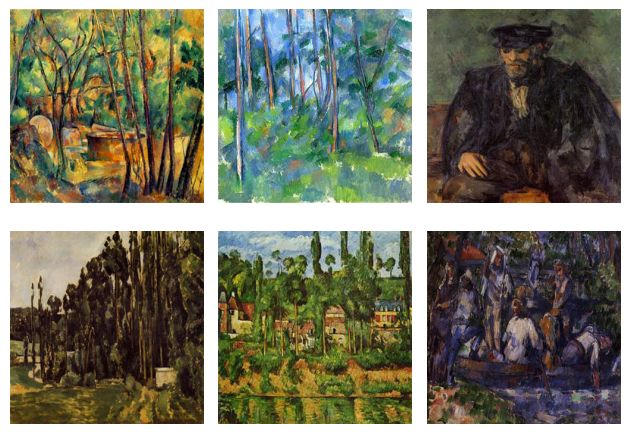

In [6]:
#take 6 random images
cazanne_photos = random.choices(os.listdir(filenames[0]),k=6)

#Create grid for plots
fig, axs = plt.subplots(2, 3)

for i,ax in enumerate(axs.flat):
  cazanne_photo = mpimg.imread(filenames[0] + "/" +cazanne_photos[i])
  ax.imshow(cazanne_photo)
  ax.axis(False);

plt.tight_layout()

Visualize some images - real style


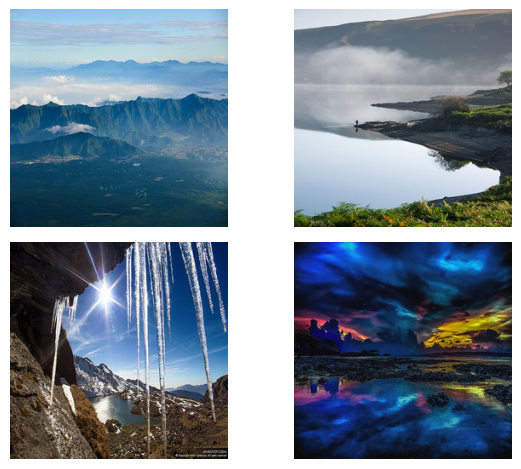

In [7]:
real_photos = random.choices(os.listdir(filenames[2]),k=4)
fig, axs = plt.subplots(2, 2)

for i,ax in enumerate(axs.flat):
  real_photo = mpimg.imread(filenames[2] + "/" +real_photos[i])
  ax.imshow(real_photo)
  ax.axis(False);

plt.tight_layout()

Create datasets for usage

In [8]:
def create_ds(path):
  images=[]
  for img in os.listdir(path):
    image = tf.keras.utils.load_img(path+img,target_size=(256,256))
    image = tf.keras.utils.img_to_array(image)
    image =(image-127.5)/127.5
    images.append(image)
  return images


In [9]:
trainA = create_ds(filenames[1] + "/")
testA = create_ds(filenames[0] + "/")

trainB = create_ds(filenames[3] + "/")
testB = create_ds(filenames[2] + "/")
len(testA),len(testB),len(trainA),len(trainB),testA[1].shape,testA[1]

(58,
 751,
 525,
 6287,
 (256, 256, 3),
 array([[[ 0.30980393,  0.22352941, -0.02745098],
         [ 0.31764707,  0.23137255, -0.01960784],
         [ 0.34117648,  0.25490198,  0.00392157],
         ...,
         [ 0.5686275 ,  0.5137255 ,  0.30980393],
         [ 0.6627451 ,  0.5921569 ,  0.3647059 ],
         [ 0.6313726 ,  0.56078434,  0.31764707]],
 
        [[ 0.25490198,  0.16862746, -0.08235294],
         [ 0.15294118,  0.06666667, -0.18431373],
         [ 0.12156863,  0.05098039, -0.20784314],
         ...,
         [ 0.29411766,  0.23921569,  0.03529412],
         [ 0.3882353 ,  0.31764707,  0.09019608],
         [ 0.4117647 ,  0.34117648,  0.09803922]],
 
        [[ 0.2784314 ,  0.20784314, -0.03529412],
         [ 0.13725491,  0.06666667, -0.19215687],
         [ 0.09803922,  0.02745098, -0.23137255],
         ...,
         [ 0.27058825,  0.22352941,  0.01960784],
         [ 0.39607844,  0.34117648,  0.12156863],
         [ 0.5058824 ,  0.4509804 ,  0.22352941]],
 
        .

CycleGan article - https://arxiv.org/pdf/1703.10593.pdf
**Important notes**:
- "Weights are initialized from a
Gaussian distribution N (0, 0.02)"

#Build Generator architecture

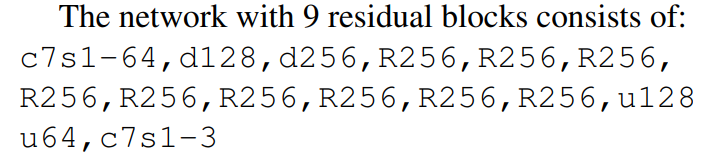

**WHERE**:
- "uk denotes a 3 × 3 fractional-strided-Convolution InstanceNorm-ReLU layer with k filters and stride 1/2"
- "dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2"
- "Rk denotes a residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layer"

In [10]:
def ResnetBlock(input_layer):
  initializer = RandomNormal(stddev=0.02)
  x = layers.Conv2D(64,(3,3),2,'same',kernel_initializer=initializer)(input_layer)
  x = InstanceNormalization(axis=-1)(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(64,(3,3),2,'same',kernel_initializer=initializer)(x)
  x = InstanceNormalization(axis=-1)(x)
  #x = layers.Activation("relu")(x)

  x = layers.Concatenate([x,input_layer])
  return x

In [11]:
def Generator(img_shape):
  initializer = RandomNormal(stddev=0.02)
  input = layers.Input(img_shape)
  #c7s1-64
  x = layers.Conv2D(64,(7,7),padding="same",kernel_initializer=initializer)(input)
  x = InstanceNormalization(axis=-1)(x)
  x = layers.Activation("relu")(x)
  #d128
  x = layers.Conv2D(128,(3,3),(2,2),"same",kernel_initializer=initializer)(x)
  x = InstanceNormalization(axis=-1)(x)
  x = layers.Activation("relu")(x)
  #d256
  x = layers.Conv2D(256,(3,3),(2,2),"same",kernel_initializer=initializer)(x)
  x = InstanceNormalization(axis=-1)(x)
  x = layers.Activation("relu")(x)
  #9xR256 - ResnetBlocks
  for i in range(9):
    x = ResnetBlock(x)
  #u128
  x = layers.Conv2DTranspose(128,(3, 3),(2, 2),'same',kernel_initializer=initializer)
  x = InstanceNormalization(axis=-1)(x)
  x = layers.Activation("relu")(x)
  #u64
  x = layers.Conv2DTranspose(64,(3, 3),(2, 2),'same',kernel_initializer=initializer)
  x = InstanceNormalization(axis=-1)(x)
  x = layers.Activation("relu")(x) 
  #c7s1-3 (RGB)
  x = layers.Conv2D(3,(7,7),padding="same",kernel_initializer=initializer)(x)
  x = InstanceNormalization(axis=-1)(x)
  x = layers.Activation("tanh")(x) #

  model = tf.keras.Model(input,x)
  return model

#Build discriminator architecture
- "The discriminator architecture is: C64-C128-C256-C512"

**WHERE**:
- "Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2"
- "We do not use
InstanceNorm for the first C64 layer. We use leaky ReLUs
with a slope of 0.2"
-"After the last layer, we apply a convolution to produce a 1-dimensional output"

In [52]:
def Discriminator(img_shape):
  initializer = RandomNormal(stddev=0.02)
  input = layers.Input(shape=img_shape)
  #C64
  x = layers.Conv2D(64,(4,4),(2,2),padding="same",kernel_initializer=initializer)(input)
  x = layers.LeakyReLU(0.2)(x)
  #C128
  x = layers.Conv2D(128,(4,4),(2,2),padding="same",kernel_initializer=initializer)(input)
  x = InstanceNormalization(axis=-1)(x)
  x = layers.LeakyReLU(0.2)(x)
  #C256
  x = layers.Conv2D(256,(4,4),(2,2),padding="same",kernel_initializer=initializer)(input)
  x = InstanceNormalization(axis=-1)(x)
  x = layers.LeakyReLU(0.2)(x) 
  #C512
  x = layers.Conv2D(512,(4,4),(2,2),padding="same",kernel_initializer=initializer)(input)
  x = InstanceNormalization(axis=-1)(x)
  x = layers.LeakyReLU(0.2)(x) 
  #OUT
  x = layers.Conv2D(1,(4,4),padding="same",kernel_initializer=initializer)(x) # 

  model = tf.keras.models.Model(input,x)
  model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5),loss_weights=[0.5])
  return model

In [53]:
dis = Discriminator((256,256,3))
wynik = dis(np.expand_dims(trainA[0],axis=0))

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [54]:
wynik.shape

TensorShape([1, 128, 128, 1])

#Building model for generators training

In [13]:
#GeneratorA goes from realistic images to Van Gogh images
#GeneratorB goes from Van Gogh images to realistic images

#Trenowane są tutaj generatory, więc dyskryminator ma trainable parameters na False
#Jeden generator w danym momencie trenowany
def Generator_training(GenA,GenB,discriminator,img_shape):
  GenA.trainable=True
  GenB.trainable=False
  dicriminator.trainable=False

  #Adversarial loss
  gen_inputA = layers.Input(img_shape)
  generatorA_outputA = GenA(gen_inputA)# Przykładowo do generatora a wchodzi realistyczne zdjecie i wychodzic ma vangogh
  outputd = discriminator(generatorA_outputA)

  #Identical loss
  gen_inputB = layers.Input(img_shape)
  generatorA_outputI = GenA(gen_inputB)#Przykładowo na generatorA wchodzi Van Gogh img i powinno po wyjściu zdjęcie być takie same

  #Consistency loss - forward
  gen_output_forward = GenB(generatorA_outputA) # wchodzi van gogh i ma być spowrotem realistyczne

  #Consistency loss - backward
  generatorB_output = GenB(gen_inputB)
  gen_output_backward = GenA(generatorB_output)

  #INPUTS - Zdjęcia  dla modelu A, Zdjęcia dla modelu B / OUTPUTS - Adversarial,Identical,Forward,Backward 
  model =tf.keras.Model([gen_inputA,gen_inputB],[outputd,generatorA_outputI,gen_output_forward,gen_output_backward]) 

  model.compile(loss=['mse','mae','mae','mae'],
                optimizer=Adam(lr=0.0002,beta_1=0.5),
                loss_weights=[1,5,10,10])
  
  return model

In [14]:
def real_images(data,num_of_img):
  img = random.randint(0,len(data),num_of_img)
  label = np.ones((len(img), img.shape[1], img.shape[2], 1))
  return img, label

In [15]:
def generate_images(generator,data):
  img = generator.predict(data)
  label = np.zeros((len(img), img.shape[1], img.shape[2], 1))#batch size/img size/img size/expanded 
  return img, label

#Buffer-discriminator Creation
- "Second, to reduce model oscillation [15], we follow
Shrivastava et al.’s strategy [46] and update the discriminators using a history of generated images rather than the
ones produced by the latest generators. We keep an image
buffer that stores the 50 previously created images."


In [10]:
def buffer_gen_img(images, buffer):
  '''
  images - Generated (fake) images
  buffer - Holds 50 random generated images - reduce of model oscillation 
  / To change
  '''
  used=[]
  #Is collecting images in buffer till it is 50 of them, then 
  size = 50
  for img in images:
    if len(buffer) < 50:
      #During first 50 images, last images are taken
      buffer.append(img)
      used.append(img)

    elif random.random() > 0.5: #50% of chance
      #Option with leaving buffer as it was
      used.append(img)#Last image will be used for discriminator

    else:
      idx = random.randint(0, len(buffer)-1)
      used.append(buffer[idx])#Random image from buffer will be used for discriminator
      buffer[idx] = img #Exchange to other image in this index

  return np.array(used)

Generatory trenowane będą przy użyciu modelu wykreowanego w "Generator_training". Natomiast modele dyskryminatorów porpzez "Discriminator"

#CycleGAN training function

In [ ]:
#GeneratorA goes from realistic images to Van Gogh images
#GeneratorB goes from Van Gogh images to realistic images
#A - is for realistic images / B - van gogh images
#GenAB means genA -> genB (so ends up with realistic images)

def train(genA,genB,genAB,genBA,normal_imgs,other_imgs,discriminatorA,discriminatorB,epochs):

  batches = 1 # 1 image in batch
  steps = epochs * len(normal_imgs)/batches #Number of iterations during training  - len(normal_imgs) number of images to train on
  #Buffer for generated images considered during discriminator training
  bufferA=[]
  bufferB=[]

  for i in range(steps):
    #Process of training

    Xa_real,ya_real = real_images(normal_imgs,???)
    Xa_fake,ya_fake = generate_images(genB,other_imgs)

    Xb_real,yb_real = real_images(other_imgs,)
    Xb_fake,yb_fake = generate_images(genA,other_imgs)

    #Losses - generator
    La,Li,Lf,Lb = genAB.train_on_batch(Xa_Real,Xb_real)#Train generator A with adversarial,identical,forward,backward loss
    La_b,Li_b,Lf_b,Lb_b = genBA.train_on_batch(Xb_Real,Xa_real)#Train generator B with adversarial,identical,forward,backward loss

    #Take random generated image for discriminator training
    Xa_fake = buffer_gen_img(Xa_fake,bufferA)
    Xb_fake = buffer_gen_img(Xb_fake,bufferB)

    #Losses - dyskryminatorA
    Ld_realA = discriminatorA.train_on_batch(Xa_real,ya_real)
    Ld_fakeA = discriminatorA.train_on_batch(Xa_fake,ya_fake)

    #Losses - dyskryminatorB
    Ld_realB = discriminatorB.train_on_batch(Xb_real,yb_real)
    Ld_fakeB = discriminatorB.train_on_batch(Xb_fake,yb_fake)

    #Information after every iteration
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, Ld_realA,Ld_fakeA, Ld_realB,Ld_fakeB, La,La_b))
    #Save model - visualize losses ...

#Prepare everything and train

#Testing reflection padding

In [ ]:
random_ints = tf.cast(tf.random.uniform(shape=(2, 3), minval=0, maxval=10), dtype=tf.int32)
paddings = tf.constant([[1, 1], [1, 1]])
x_padded = tf.pad(random_ints, paddings, mode='REFLECT')
random_ints

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[6, 9, 3],
       [9, 8, 3]], dtype=int32)>

In [ ]:
x_padded

<tf.Tensor: shape=(4, 5), dtype=int32, numpy=
array([[8, 9, 8, 3, 8],
       [9, 6, 9, 3, 9],
       [8, 9, 8, 3, 8],
       [9, 6, 9, 3, 9]], dtype=int32)>

In [ ]:
paddings2=tf.constant([[1, 1], [2,2]])
x_padded2 = tf.pad(random_ints, paddings2, mode='REFLECT')
x_padded2

<tf.Tensor: shape=(4, 7), dtype=int32, numpy=
array([[3, 8, 9, 8, 3, 8, 9],
       [3, 9, 6, 9, 3, 9, 6],
       [3, 8, 9, 8, 3, 8, 9],
       [3, 9, 6, 9, 3, 9, 6]], dtype=int32)>